# Trabalho Final de Aprendizado de Máquina
### Aluna: Aicha Khalid Hassan Al-Rob

##### Este trabalho utilizará como base um dataset de videoclipes do Youtube, disponível no Kaggle, que pode ser encontrado [aqui](https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset). O objetivo é prever se um vídeo será ou não tendência no Youtube, baseado em suas características.


Vamos, primeiro, importar as bibliotecas necessárias para o trabalho.


In [53]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
from sentence_transformers import SentenceTransformer
import re
import collections
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Armazenando o dataset em um dataframe do Pandas, para a manipulação dos dados.

In [2]:
data_br = pd.read_csv('archive/BR_youtube_trending_data.csv')
data_br.head()
data_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240790 entries, 0 to 240789
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           240790 non-null  object
 1   title              240790 non-null  object
 2   publishedAt        240790 non-null  object
 3   channelId          240790 non-null  object
 4   channelTitle       240790 non-null  object
 5   categoryId         240790 non-null  int64 
 6   trending_date      240790 non-null  object
 7   tags               240790 non-null  object
 8   view_count         240790 non-null  int64 
 9   likes              240790 non-null  int64 
 10  dislikes           240790 non-null  int64 
 11  comment_count      240790 non-null  int64 
 12  thumbnail_link     240790 non-null  object
 13  comments_disabled  240790 non-null  bool  
 14  ratings_disabled   240790 non-null  bool  
 15  description        230462 non-null  object
dtypes: bool(2), int64(5)

Usaremos apenas os dados do Youtube Brasil, mas o dataset contém dados de outros países também. Carreguei os videos do México num outro dataframe apenas para dar uma olhadinha, mas não utilizei-o no trabalho.

In [94]:
data_mex = pd.read_csv('archive/MX_youtube_trending_data.csv')
data_mex.head(10)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,SsWHMAhshPQ,Ovi x Natanael Cano x Aleman x Big Soto - Veng...,2020-08-11T23:00:10Z,UC648rgJOboZlgcDbW00vTSA,Rancho Humilde,10,2020-08-12T00:00:00Z,Vengo De Nada|Aleman|Ovi|Big Soto|Trap|Ovi Nat...,741028,113999,4380,5620,https://i.ytimg.com/vi/SsWHMAhshPQ/default.jpg,False,False,Vengo De Nada - Ovi x Natanael Cano x Aleman x...
1,JOaeND0xUNk,Belinda y Christian Nodal cantan De los besos ...,2020-08-11T18:03:06Z,UCNVrBkfp4_TG9x4h5kvLeAQ,TV Azteca,24,2020-08-12T00:00:00Z,tv azteca|videos de tv azteca|azteca uno|en su...,402507,8102,831,803,https://i.ytimg.com/vi/JOaeND0xUNk/default.jpg,False,False,Encendieron el escenario de La Voz. TV AztecaT...
2,SV91jnGs--s,¿QUIÉN HACE LOS MEJORES NUGGETS? | EL GUZII,2020-08-11T19:57:02Z,UCuGn3ioftOo6jvHE1YK4Bfw,El Guzii,26,2020-08-12T00:00:00Z,El Guzii|Guzzi|Guzy|Guzii Style|Recetas Divert...,735044,62188,1053,4100,https://i.ytimg.com/vi/SV91jnGs--s/default.jpg,False,False,Si tienes 10 kg de sobre peso tal vez te haz p...
3,QgX0zn5nMyk,Martha Figueroa se disculpa públicamente con N...,2020-08-11T15:57:47Z,UCJPd6seu4JK4PZjVVTWb0QA,Hoy,24,2020-08-12T00:00:00Z,Televisa|Televisa espectaculos|programa hoy te...,521751,4680,3129,2285,https://i.ytimg.com/vi/QgX0zn5nMyk/default.jpg,False,False,Mira aquí el contenido exclusivo que tenemos p...
4,cKaM19oAwBM,MAQUILLAJE PARA KIMBERLY LOAIZA✨ RESISTENTE AL...,2020-08-11T21:55:08Z,UCs5w0QCxsEWz83vuQyOCnuA,Victor Guadarrama,26,2020-08-12T00:00:00Z,MAQUILLAJE|CELEBS|ARTE|MAKEUP|PESTAÑAS|KIMBERL...,168118,24551,537,782,https://i.ytimg.com/vi/cKaM19oAwBM/default.jpg,False,False,No olvides suscribirte y activar la campanita ...
5,zU5lgsAKIIA,NOVIO VS. NOVIA - MaiLu,2020-08-11T20:18:23Z,UCj4HkE5zO2aSU_LUv4fHB8A,MaiLu,22,2020-08-12T00:00:00Z,lulu99|novio de lulu99|lulu y su novio|maicol ...,989033,157522,2060,18314,https://i.ytimg.com/vi/zU5lgsAKIIA/default.jpg,False,False,"Hola MaiLutubers, bienvenidos al nuestro canal..."
6,p7WtYeowOEY,LA VENGANZA ES DULCE 😳 //CEVICHURRO VS TRIKI T...,2020-08-12T01:00:04Z,UCUhXAsbSWi7s34-imeLyatg,SOY TRIKI TRIKI,22,2020-08-12T00:00:00Z,Triki triki|Payaso triki trki|Soy triki triki,64858,6327,110,437,https://i.ytimg.com/vi/p7WtYeowOEY/default.jpg,False,False,el video anterior este en el canal de los cevi...
7,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146744,2794,16557,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
8,8PaPyFpt3FE,¡Erika Buenfil enfrenta a Pepillo Origel y pid...,2020-08-10T17:13:40Z,UCJPd6seu4JK4PZjVVTWb0QA,Hoy,24,2020-08-12T00:00:00Z,Televisa|Televisa espectaculos|programa hoy te...,1176350,15569,2431,3937,https://i.ytimg.com/vi/8PaPyFpt3FE/default.jpg,False,False,Mira aquí el contenido exclusivo que tenemos p...
9,jbGRowa5tIk,ITZY “Not Shy” M/V TEASER,2020-08-11T15:00:13Z,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,10,2020-08-12T00:00:00Z,JYP Entertainment|JYP|ITZY|있지|ITZY Video|ITZY ...,6000070,714314,15176,31050,https://i.ytimg.com/vi/jbGRowa5tIk/default.jpg,False,False,ITZY Not Shy M/V[ITZY Official] https://www.yo...


> **removendo colunas que nao agregariam na nossa analise:**


In [4]:
# removendo colunas que nao agregariam na nossa analise
data_br.drop(columns=['video_id','thumbnail_link', 'channelId'], inplace=True, errors='ignore')
data_br.head()

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11T22:21:49Z,Pietro Guedes,22,2020-08-12T00:00:00Z,pietro|guedes|ingrid|ohara|pingrid|vlog|amigos...,263835,85095,487,4500,False,False,"Salve rapaziada, neste vídeo me declarei pra e..."
1,ITZY “Not Shy” M/V TEASER,2020-08-11T15:00:13Z,JYP Entertainment,10,2020-08-12T00:00:00Z,JYP Entertainment|JYP|ITZY|있지|ITZY Video|ITZY ...,6000070,714310,15176,31040,False,False,ITZY Not Shy M/V[ITZY Official] https://www.yo...
2,Oh Juliana PARÓDIA - MC Niack,2020-08-10T14:59:00Z,As Irmãs Mota,22,2020-08-12T00:00:00Z,OH JULIANA PARÓDIA|MC Niack PARÓDIA|PARÓDIAS|A...,2296748,39761,5484,0,True,False,Se inscrevam meus amores! 📬 Quer nos mandar al...
3,Contos de Runeterra: Targon | A Estrada Tortuosa,2020-08-11T15:00:09Z,League of Legends BR,20,2020-08-12T00:00:00Z,Riot|Riot Games|League of Legends|lol|trailer|...,300510,46222,242,2748,False,False,Você se unirá aos Lunari e aos Solari em Targo...
4,Entrevista com Thammy Miranda | The Noite (10/...,2020-08-11T20:04:02Z,The Noite com Danilo Gentili,23,2020-08-12T00:00:00Z,The Noite|The Noite com Danilo Gentili|Danilo ...,327235,22059,3972,2751,False,False,Danilo Gentili recebe Thammy Miranda. Após pas...


In [5]:
# sustituindo categoryid pela categoria correspondente, pegando-a no arquivo JSON
with open('archive/BR_category_id.json') as f:
    categories_br = json.load(f)
categories_br, list_category = categories_br['items'], len(categories_br['items'])
name_category = [categories_br[i]['snippet']['title'] for i in range(list_category)]
id_category = [int(categories_br[i]['id']) for i in range(list_category)]
print('O número de categorias é: ', list_category)
#print('\nA lista de categorias é: ', categories_br)
print('\nAs categorias são: ', name_category)
print('\nO id das categorias: ', id_category)

categories_dict = dict(zip(id_category, name_category))
print('\nO dicionário de categorias é: \n', categories_dict)



O número de categorias é:  31

As categorias são:  ['Film & Animation', 'Autos & Vehicles', 'Music', 'Pets & Animals', 'Sports', 'Short Movies', 'Travel & Events', 'Gaming', 'Videoblogging', 'People & Blogs', 'Comedy', 'Entertainment', 'News & Politics', 'Howto & Style', 'Education', 'Science & Technology', 'Movies', 'Anime/Animation', 'Action/Adventure', 'Classics', 'Comedy', 'Documentary', 'Drama', 'Family', 'Foreign', 'Horror', 'Sci-Fi/Fantasy', 'Thriller', 'Shorts', 'Shows', 'Trailers']

O id das categorias:  [1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]

O dicionário de categorias é: 
 {1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 30: '

In [6]:
data_br['category_name'] = data_br['categoryId'].map(categories_dict)
data_br.head()


,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category_name
0,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11T22:21:49Z,Pietro Guedes,22,2020-08-12T00:00:00Z,pietro|guedes|ingrid|ohara|pingrid|vlog|amigos...,263835,85095,487,4500,False,False,"Salve rapaziada, neste vídeo me declarei pra e...",People & Blogs
1,ITZY “Not Shy” M/V TEASER,2020-08-11T15:00:13Z,JYP Entertainment,10,2020-08-12T00:00:00Z,JYP Entertainment|JYP|ITZY|있지|ITZY Video|ITZY ...,6000070,714310,15176,31040,False,False,ITZY Not Shy M/V[ITZY Official] https://www.yo...,Music
2,Oh Juliana PARÓDIA - MC Niack,2020-08-10T14:59:00Z,As Irmãs Mota,22,2020-08-12T00:00:00Z,OH JULIANA PARÓDIA|MC Niack PARÓDIA|PARÓDIAS|A...,2296748,39761,5484,0,True,False,Se inscrevam meus amores! 📬 Quer nos mandar al...,People & Blogs
3,Contos de Runeterra: Targon | A Estrada Tortuosa,2020-08-11T15:00:09Z,League of Legends BR,20,2020-08-12T00:00:00Z,Riot|Riot Games|League of Legends|lol|trailer|...,300510,46222,242,2748,False,False,Você se unirá aos Lunari e aos Solari em Targo...,Gaming
4,Entrevista com Thammy Miranda | The Noite (10/...,2020-08-11T20:04:02Z,The Noite com Danilo Gentili,23,2020-08-12T00:00:00Z,The Noite|The Noite com Danilo Gentili|Danilo ...,327235,22059,3972,2751,False,False,Danilo Gentili recebe Thammy Miranda. Após pas...,Comedy


O professor solicitou para que eu reduzisse o dataset para 1000 linhas para cada categoria, 


In [7]:
# reduzindo o conjunto de dados para uns 1000 registros por categoria. São 29 categorias, então 29 mil registros

# contando quantos tem por categoria
data_br['category_name'].value_counts()

category_name
Entertainment           58712
Music                   53365
Gaming                  35407
Sports                  35317
People & Blogs          29895
Comedy                   9734
News & Politics          3891
Science & Technology     3202
Education                2943
Film & Animation         2746
Autos & Vehicles         2249
Howto & Style            1844
Travel & Events          1116
Pets & Animals            301
Name: count, dtype: int64

In [8]:
data_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240790 entries, 0 to 240789
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   title              240790 non-null  object
 1   publishedAt        240790 non-null  object
 2   channelTitle       240790 non-null  object
 3   categoryId         240790 non-null  int64 
 4   trending_date      240790 non-null  object
 5   tags               240790 non-null  object
 6   view_count         240790 non-null  int64 
 7   likes              240790 non-null  int64 
 8   dislikes           240790 non-null  int64 
 9   comment_count      240790 non-null  int64 
 10  comments_disabled  240790 non-null  bool  
 11  ratings_disabled   240790 non-null  bool  
 12  description        230462 non-null  object
 13  category_name      240722 non-null  object
dtypes: bool(2), int64(5), object(7)
memory usage: 22.5+ MB


In [9]:
# data_br[data_br['category_name'] == 'Music'].head()
data_br[data_br['category_name'] == 'Entertainment']._is_view

False

As colunas `publishedAt` e `trending_date` tem dia e hora. Vou separar em dois campos diferentes, para facilitar a análise.

In [10]:
# publishedAt e trending_date tem dia e hora. Vamos separar em dois atributos diferentes
pd.options.mode.chained_assignment = None  # default='warn'

def get_date(date):
    return date.split('T')[0]

def get_time(time):
    #return time.split('T')[1]
    # formatando a hora, e convertendo para o formato de 24h
    try:
        return pd.to_datetime(time.split('T')[1]).strftime('%H:%M:%S')
    except:
        return pd.to_datetime('00:00:00').strftime('%H:%M:%S')
    

data_br['published_date'] = data_br['publishedAt'].apply(get_date)
data_br['published_time'] = data_br['publishedAt'].apply(get_time)

data_br['trending_date'] = data_br['trending_date'].apply(get_date)

data_br.head()


,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category_name,published_date,published_time
0,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11T22:21:49Z,Pietro Guedes,22,2020-08-12,pietro|guedes|ingrid|ohara|pingrid|vlog|amigos...,263835,85095,487,4500,False,False,"Salve rapaziada, neste vídeo me declarei pra e...",People & Blogs,2020-08-11,22:21:49
1,ITZY “Not Shy” M/V TEASER,2020-08-11T15:00:13Z,JYP Entertainment,10,2020-08-12,JYP Entertainment|JYP|ITZY|있지|ITZY Video|ITZY ...,6000070,714310,15176,31040,False,False,ITZY Not Shy M/V[ITZY Official] https://www.yo...,Music,2020-08-11,15:00:13
2,Oh Juliana PARÓDIA - MC Niack,2020-08-10T14:59:00Z,As Irmãs Mota,22,2020-08-12,OH JULIANA PARÓDIA|MC Niack PARÓDIA|PARÓDIAS|A...,2296748,39761,5484,0,True,False,Se inscrevam meus amores! 📬 Quer nos mandar al...,People & Blogs,2020-08-10,14:59:00
3,Contos de Runeterra: Targon | A Estrada Tortuosa,2020-08-11T15:00:09Z,League of Legends BR,20,2020-08-12,Riot|Riot Games|League of Legends|lol|trailer|...,300510,46222,242,2748,False,False,Você se unirá aos Lunari e aos Solari em Targo...,Gaming,2020-08-11,15:00:09
4,Entrevista com Thammy Miranda | The Noite (10/...,2020-08-11T20:04:02Z,The Noite com Danilo Gentili,23,2020-08-12,The Noite|The Noite com Danilo Gentili|Danilo ...,327235,22059,3972,2751,False,False,Danilo Gentili recebe Thammy Miranda. Após pas...,Comedy,2020-08-11,20:04:02


In [11]:
print('PublishedAt é do tipo ', type(data_br['publishedAt'][0]))
print('published_date é do tipo ', type(data_br['published_date'][0]))
print('published_time é do tipo ', type(data_br['published_time'][0]))

PublishedAt é do tipo  <class 'str'>
published_date é do tipo  <class 'str'>
published_time é do tipo  <class 'str'>


In [12]:
# transformando published_date e e published_time em datetime
data_br['published_date'] = pd.to_datetime(data_br['published_date'])
data_br['published_time'] = pd.to_datetime(data_br['published_time'], format='%H:%M:%S')

data_br.drop(columns=['publishedAt'], inplace=True, errors='ignore')

# data_br['published_time'] = datetime.strptime(data_br['published_time'], '%H:%M:%S')
# data_br['published_date'] = datetime.strptime(data_br['published_date'], '%Y-%m-%d')

print('published_date é do tipo ', type(data_br['published_date'][0]))
print('published_time é do tipo ', type(data_br['published_time'][0]))

published_date é do tipo  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
published_time é do tipo  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [13]:
#separando as tags da coluna tags
data_br['tags'] = data_br['tags'].apply(lambda x: x.split('|'))


In [14]:
data_br.head()

,title,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category_name,published_date,published_time
0,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,Pietro Guedes,22,2020-08-12,"[pietro, guedes, ingrid, ohara, pingrid, vlog,...",263835,85095,487,4500,False,False,"Salve rapaziada, neste vídeo me declarei pra e...",People & Blogs,2020-08-11,1900-01-01 22:21:49
1,ITZY “Not Shy” M/V TEASER,JYP Entertainment,10,2020-08-12,"[JYP Entertainment, JYP, ITZY, 있지, ITZY Video,...",6000070,714310,15176,31040,False,False,ITZY Not Shy M/V[ITZY Official] https://www.yo...,Music,2020-08-11,1900-01-01 15:00:13
2,Oh Juliana PARÓDIA - MC Niack,As Irmãs Mota,22,2020-08-12,"[OH JULIANA PARÓDIA, MC Niack PARÓDIA, PARÓDIA...",2296748,39761,5484,0,True,False,Se inscrevam meus amores! 📬 Quer nos mandar al...,People & Blogs,2020-08-10,1900-01-01 14:59:00
3,Contos de Runeterra: Targon | A Estrada Tortuosa,League of Legends BR,20,2020-08-12,"[Riot, Riot Games, League of Legends, lol, tra...",300510,46222,242,2748,False,False,Você se unirá aos Lunari e aos Solari em Targo...,Gaming,2020-08-11,1900-01-01 15:00:09
4,Entrevista com Thammy Miranda | The Noite (10/...,The Noite com Danilo Gentili,23,2020-08-12,"[The Noite, The Noite com Danilo Gentili, Dani...",327235,22059,3972,2751,False,False,Danilo Gentili recebe Thammy Miranda. Após pas...,Comedy,2020-08-11,1900-01-01 20:04:02


In [15]:
type(data_br['tags'][0])

list

In [16]:
# descobrir o dia de semana em que o video estava em trending
data_br['trending_weekday'] = data_br['trending_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())
# substituindo o numero do dia da semana pelo nome
data_br['trending_weekday'] = data_br['trending_weekday'].replace([0,1,2,3,4,5,6], ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'])
data_br.head()

,title,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category_name,published_date,published_time,trending_weekday
0,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,Pietro Guedes,22,2020-08-12,"[pietro, guedes, ingrid, ohara, pingrid, vlog,...",263835,85095,487,4500,False,False,"Salve rapaziada, neste vídeo me declarei pra e...",People & Blogs,2020-08-11,1900-01-01 22:21:49,Quarta
1,ITZY “Not Shy” M/V TEASER,JYP Entertainment,10,2020-08-12,"[JYP Entertainment, JYP, ITZY, 있지, ITZY Video,...",6000070,714310,15176,31040,False,False,ITZY Not Shy M/V[ITZY Official] https://www.yo...,Music,2020-08-11,1900-01-01 15:00:13,Quarta
2,Oh Juliana PARÓDIA - MC Niack,As Irmãs Mota,22,2020-08-12,"[OH JULIANA PARÓDIA, MC Niack PARÓDIA, PARÓDIA...",2296748,39761,5484,0,True,False,Se inscrevam meus amores! 📬 Quer nos mandar al...,People & Blogs,2020-08-10,1900-01-01 14:59:00,Quarta
3,Contos de Runeterra: Targon | A Estrada Tortuosa,League of Legends BR,20,2020-08-12,"[Riot, Riot Games, League of Legends, lol, tra...",300510,46222,242,2748,False,False,Você se unirá aos Lunari e aos Solari em Targo...,Gaming,2020-08-11,1900-01-01 15:00:09,Quarta
4,Entrevista com Thammy Miranda | The Noite (10/...,The Noite com Danilo Gentili,23,2020-08-12,"[The Noite, The Noite com Danilo Gentili, Dani...",327235,22059,3972,2751,False,False,Danilo Gentili recebe Thammy Miranda. Após pas...,Comedy,2020-08-11,1900-01-01 20:04:02,Quarta


In [17]:
# removendo pontuação e caracteres especiais de description e title
data_br = data_br.replace(re.compile('<.*?>'), '')
data_br = data_br.replace(re.compile('[^a-zA-Z0-9 ]'), '')

# deixando tudo em letra minuscula
data_br['title'] = data_br['title'].apply(lambda x: x.lower())
data_br['channelTitle'] = data_br['channelTitle'].apply(lambda x: x.lower())
data_br['tags'] = data_br['tags'].apply(lambda x: [i.lower() for i in x])
data_br['description'] = data_br['description'].apply(lambda x: x.lower() if type(x) == str else x)
print(type(data_br['tags'][0]))
data_br.head()

<class 'list'>


,title,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category_name,published_date,published_time,trending_weekday
0,levei um fora fingi estar apaixonado por ela,pietro guedes,22,20200812,"[pietro, guedes, ingrid, ohara, pingrid, vlog,...",263835,85095,487,4500,False,False,salve rapaziada neste vdeo me declarei pra ela...,People Blogs,2020-08-11,1900-01-01 22:21:49,Quarta
1,itzy not shy mv teaser,jyp entertainment,10,20200812,"[jyp entertainment, jyp, itzy, 있지, itzy video,...",6000070,714310,15176,31040,False,False,itzy not shy mvitzy official httpswwwyoutubeco...,Music,2020-08-11,1900-01-01 15:00:13,Quarta
2,oh juliana pardia mc niack,as irms mota,22,20200812,"[oh juliana paródia, mc niack paródia, paródia...",2296748,39761,5484,0,True,False,se inscrevam meus amores quer nos mandar algo...,People Blogs,2020-08-10,1900-01-01 14:59:00,Quarta
3,contos de runeterra targon a estrada tortuosa,league of legends br,20,20200812,"[riot, riot games, league of legends, lol, tra...",300510,46222,242,2748,False,False,voc se unir aos lunari e aos solari em targon ...,Gaming,2020-08-11,1900-01-01 15:00:09,Quarta
4,entrevista com thammy miranda the noite 100820,the noite com danilo gentili,23,20200812,"[the noite, the noite com danilo gentili, dani...",327235,22059,3972,2751,False,False,danilo gentili recebe thammy miranda aps passa...,Comedy,2020-08-11,1900-01-01 20:04:02,Quarta


In [18]:
my_counter = collections.Counter()

for tags in data_br['tags']:
    my_counter.update(tags) # atualiza o contador com os elementos da lista tags

print('As palavras mais comuns nas tags são: ', my_counter.most_common(10))


As palavras mais comuns nas tags são:  [('[none]', 36023), ('futebol', 13047), ('minecraft', 11793), ('humor', 7617), ('vlog', 7307), ('gols', 6861), ('melhores momentos', 6775), ('ao vivo', 6751), ('flamengo', 6719), ('brasil', 6373)]


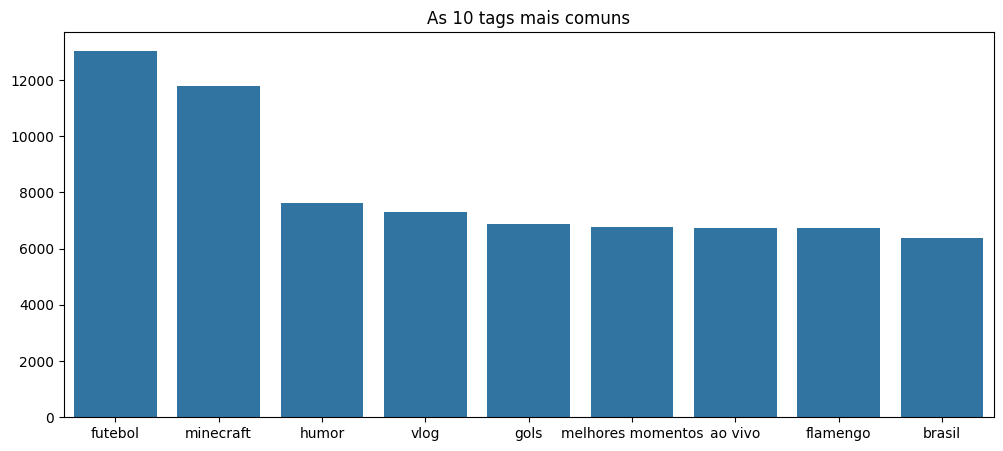

In [19]:
# removendo o none da lista de tags
top10_tags = my_counter.most_common(10)

tags = [i[0] for i in my_counter.most_common(10) if i[0] != '[none]']
# removendo o item 'none' da lista de tags

counts = [i[1] for i in my_counter.most_common(10) if i[0] != '[none]']

plt.figure(figsize=(12,5))
sns.barplot(x=tags, y=counts)
plt.title('As 10 tags mais comuns')
plt.show()


Aqui podemos ver os principais temas de videos que se popularizam no youtube nesse contexto.

Gerando mais uma coluna com o embedding a partir do campo tags processado, usando TF-IDF. Mas primeiro, vamos remover as tags que aparecem apenas uma vez, pois não agregam muito.

In [56]:
# def transform_to_embeddings(data, column, embedding_model):
#     embeddings = []
#     for idx, item in data.iterrows():
#         text = str(item[column])
#         embedding = embedding_model.encode([text])[0]
#         embeddings.append(embedding.tolist())
#     return embeddings

In [61]:
data_br.drop_duplicates(subset=['title'], inplace=True)
data_br.shape

(36672, 18)

In [62]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Selecionando a coluna 'title'
titles = data_br['title']

# Criando o modelo TF-IDF e transformando os títulos
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(titles)

In [68]:
print('Tamanho da matriz TF-IDF: ', tfidf_matrix.shape)
print(type(tfidf_matrix))
print('Primeiros 3 vetores de embeddings: \n', tfidf_matrix[0:3])

Tamanho da matriz TF-IDF:  (36672, 28057)
<class 'scipy.sparse._csr.csr_matrix'>
Primeiros 3 vetores de embeddings: 
   (0, 9668)	0.3005015026095538
  (0, 20730)	0.24535759382502556
  (0, 2919)	0.4213489133381656
  (0, 10616)	0.4213489133381656
  (0, 11649)	0.43096176439310707
  (0, 11906)	0.33577461018424865
  (0, 26475)	0.21585700751213233
  (0, 15848)	0.38647355101480263
  (1, 25229)	0.3364078307693308
  (1, 18261)	0.32988244825844676
  (1, 23897)	0.5577181286544826
  (1, 18828)	0.4915672260480782
  (1, 14575)	0.47467830472186723
  (2, 18655)	0.5564393318993585
  (2, 17134)	0.2929955296810324
  (2, 19687)	0.3637669930063191
  (2, 14989)	0.4662235560653938
  (2, 19088)	0.5048148770303884


In [70]:
# Calculando a similaridade do cosseno
cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix).flatten()

# Criando um DataFrame com os títulos e suas similaridades
similarities_df = pd.DataFrame({'title': titles, 'similarity': cosine_similarities})

# Ordenando os resultados para mostrar os mais similares
sorted_similarities_df = similarities_df.sort_values(by='similarity', ascending=False)
sorted_similarities_df.head(20)


,title,similarity
0,levei um fora fingi estar apaixonado por ela,1.000000
19416,fingi ser a barbie por um dia inteiro,0.340543
77408,ela e ela,0.300502
83022,levei um chute shorts,0.281104
57619,fingi ser mandraka por 24 horas,0.278357
70418,levei minha me nas lojas e ela escolheu tudo q...,0.277361
116618,levei ela no medico e ele pediu um teste de gr...,0.275620
49393,levei a bruna na casa nova ela ficou em choque,0.264243
177241,expulsei ele por estar muito velho,0.259813
108220,levei minha casa para passear no minecraft e e...,0.243020


In [72]:
data_br.drop_duplicates(subset=['title'], inplace=True)

# vamos usar o modelo de embeddings do BERT para calcular a similaridade entre os titulos
# carregando o modelo
model = SentenceTransformer('all-MiniLM-L6-v2')
titles = data_br['title'].tolist()
title_embeddings = model.encode(titles)


In [74]:
print(type(title_embeddings))
print('Tamanho do array de embeddings: ', len(title_embeddings))
print('primeiro vetor de embeddings: \n', title_embeddings[0])


<class 'numpy.ndarray'>
Tamanho do array de embeddings:  36672
primeiro vetor de embeddings: 
 [-1.86900899e-03  2.48207208e-02  6.55640801e-03 -1.65577270e-02
 -5.84614761e-02  3.99157889e-02  1.79824010e-02  3.71072404e-02
  5.06533273e-02  5.10269739e-02  9.87139568e-02  1.45684620e-02
 -3.78349498e-02 -4.79080193e-02 -1.25657227e-02  1.88533813e-02
 -7.28663206e-02 -1.25037460e-02  5.01298951e-03  1.94283929e-02
  1.20301224e-01 -6.28238171e-02 -4.85856421e-02  9.19624791e-03
 -7.76642039e-02  6.30536228e-02  3.75537761e-03 -3.04264501e-02
 -2.00570188e-02 -1.48733621e-02 -2.00752262e-02  7.05002248e-02
  4.29966785e-02  1.98271498e-03 -2.30976027e-02  3.21984179e-02
  3.75295281e-02 -1.08074613e-01  4.39666845e-02  2.69260071e-02
 -7.90801644e-02 -8.10328200e-02 -1.87920202e-02 -8.43647122e-02
  2.59891916e-02 -8.74336734e-02  1.36671886e-02  4.58062775e-02
  6.46944195e-02 -2.17405520e-02 -3.23591940e-02 -4.54013720e-02
 -1.83692425e-02 -6.31457046e-02  1.13886483e-02  2.72834338

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculando a similaridade do cosseno entre o primeiro título e todos os outros
cosine_similarities = cosine_similarity([title_embeddings[0]], title_embeddings)

# Criando um DataFrame para visualizar os títulos e suas similaridades
similarities_df = pd.DataFrame({'title': data_br['title'], 'similarity': cosine_similarities.flatten()})

# Ordenando os resultados para mostrar os mais similares
sorted_similarities_df = similarities_df.sort_values(by='similarity', ascending=False)


In [78]:
# Exibindo os top 10 títulos mais similares
sorted_similarities_df.head(10)

,title,similarity
0,levei um fora fingi estar apaixonado por ela,1.000000
84393,fingindo que t estudando,0.681509
202413,enganei meu amigo fingindo estar cego,0.668717
31406,trollei o meu namorado fingindo terminar com e...,0.658666
167623,o desconhecido fingiu estar fazendo uma obra p...,0.652347
204998,levamos uma bexiga at o fundo do mar,0.648317
176405,me fingi de me pra espiar meus amigos,0.637826
103205,cuidado ao julgar as pessoas pela aparncia,0.628545
105619,ele pediu ela em namoro e fez uma grande surpr...,0.627231
117420,levei meus amigos para um acampamento comigo,0.622450


In [92]:
# Instalando spaCy
!pip install spacy

# Baixando e instalando o modelo de linguagem médio para inglês
!python -m spacy download en_core_web_md
!python -m spacy link pt_core_web_md

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Usage: python -m spacy link [OPTIONS] ARGS KWARGS
Try 'python -m spacy link --help' for help.

Error: Missing argument 'KWARGS'.


In [91]:
import spacy

# Carregar o modelo de linguagem do spaCy
nlp = spacy.load('en_core_web_md')

# Função para calcular o embedding médio
def average_embedding(doc):
    return np.mean([token.vector for token in doc], axis=0) if doc else np.zeros((nlp.vocab.vectors_length,))

# Concatenando todas as tags de cada linha em uma string
tag_texts = [' '.join(tags) for tags in data_br['tags']]

# Processando em lote
embeddings = [average_embedding(doc) for doc in nlp.pipe(tag_texts)]

# Adicionando os embeddings ao DataFrame
data_br['tags_embedding'] = embeddings

In [93]:
data_br.head(10)

,title,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,category_name,published_date,published_time,trending_weekday,tags_count,tags_sum,tags_embedding
0,levei um fora fingi estar apaixonado por ela,pietro guedes,22,20200812,"[pietro, guedes, ingrid, ohara, pingrid, vlog,...",263835,85095,487,4500,False,False,salve rapaziada neste vdeo me declarei pra ela...,People Blogs,2020-08-11,1900-01-01 22:21:49,Quarta,14,pietro guedes ingrid ohara pingrid vlog amigos...,"[-0.11644212, 0.14092788, -0.68280137, -0.5520..."
1,itzy not shy mv teaser,jyp entertainment,10,20200812,"[jyp entertainment, jyp, itzy, 있지, itzy video,...",6000070,714310,15176,31040,False,False,itzy not shy mvitzy official httpswwwyoutubeco...,Music,2020-08-11,1900-01-01 15:00:13,Quarta,47,jyp entertainment jyp itzy 있지 itzy video itzy ...,"[-0.34282357, 1.1394668, -0.36862957, -0.34940..."
2,oh juliana pardia mc niack,as irms mota,22,20200812,"[oh juliana paródia, mc niack paródia, paródia...",2296748,39761,5484,0,True,False,se inscrevam meus amores quer nos mandar algo...,People Blogs,2020-08-10,1900-01-01 14:59:00,Quarta,7,oh juliana paródia mc niack paródia paródias a...,"[0.15304334, -0.97385, -1.0558299, -0.8212489,..."
3,contos de runeterra targon a estrada tortuosa,league of legends br,20,20200812,"[riot, riot games, league of legends, lol, tra...",300510,46222,242,2748,False,False,voc se unir aos lunari e aos solari em targon ...,Gaming,2020-08-11,1900-01-01 15:00:09,Quarta,42,riot riot games league of legends lol trailer ...,"[-1.2753973, -1.0715444, -0.569726, 0.19458239..."
4,entrevista com thammy miranda the noite 100820,the noite com danilo gentili,23,20200812,"[the noite, the noite com danilo gentili, dani...",327235,22059,3972,2751,False,False,danilo gentili recebe thammy miranda aps passa...,Comedy,2020-08-11,1900-01-01 20:04:02,Quarta,22,the noite the noite com danilo gentili danilo ...,"[-0.49114048, -0.24795592, -0.25066838, 0.3593..."
5,dicas da rodada 2 cartola fc 2020 bora mitar ...,cartoleiros gazeta do povo,17,20200812,"[cartola, cartola fc, cartola 2020, dicas cart...",117217,14220,106,785,False,False,no vdeo time principal time para liga tiro cur...,Sports,2020-08-11,1900-01-01 17:14:20,Quarta,12,cartola cartola fc cartola 2020 dicas cartola ...,"[0.8726929, 0.4920791, 0.3265353, 0.4293144, -..."
6,live playlist da tay,tayara andreza,10,20200812,[[none]],93022,7595,166,136,False,False,playlistdatay tayaraandreza taydeumjeitodifere...,Music,2020-08-12,1900-01-01 03:31:08,Quarta,1,[none],"[6.2510667, -4.1654, 7.459133, -2.5519333, -1...."
7,pedi ela em namoro fiz um jantar romntico pra ela,peixe,24,20200812,"[peixe, peixinho]",1427499,225365,2287,9647,False,False,neste video espero que se divirtam canais dos ...,Entertainment,2020-08-11,1900-01-01 00:02:35,Quarta,2,peixe peixinho,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,ao vivo apresentao do meia carlinhos e batepa...,vasco tv,17,20200812,"[#vasco, #vascodagama, #vascotv, #futebolbrasi...",97711,17153,65,226,False,False,NaN,Sports,2020-08-12,1900-01-01 00:58:57,Quarta,4,#vasco #vascodagama #vascotv #futebolbrasileiro,"[3.3488326, 0.87213755, 0.99683, 0.38601747, -..."
9,masterchef brasil 11082020 parte 2 ep 05 te...,masterchef brasil,24,20200812,"[masterchef temporada 7, participantes do mast...",199577,7700,129,874,False,False,assista parte 2 do episdio 5 da 7 temporada d...,Entertainment,2020-08-12,1900-01-01 08:02:01,Quarta,19,masterchef temporada 7 participantes do master...,"[-0.012662759, -1.4224869, 0.18315418, -0.0107..."


In [60]:
# embedding_model = SentenceTransformer('bert-base-nli-mean-tokens')
# title_embeddings = transform_to_embeddings(data_br, 'title', embedding_model)


KeyboardInterrupt: 

In [22]:
# gerando embeddings a partir do campo das tags, usando SBERT

# carregando o modelo pré-treinado
#embedding_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
#embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [50]:

# criando uma funcao para criar embeddings de acordo com categoria
# def transform_to_embeddings(data, column):
#     # criando uma lista de listas, onde cada lista interna é uma lista de tags
#     sentences = data[column].tolist()
#     # transformando a lista de listas em uma lista só
#     sentences = [i for j in sentences for i in j]
#     # removendo duplicatas
#     sentences = list(set(sentences))
#     # criando um dicionario, onde a chave é a tag e o valor é o embedding
#     embeddings = dict(zip(sentences, model.encode(sentences)))
#     # criando uma coluna com os embeddings
#     data['embeddings'] = data[column].apply(lambda x: [embeddings[i] for i in x])
#     return data

# def transform_to_embeddings(data, embedding_model):
#     embeddings = []
#     for idx,item in data.iterrows():
#         concatenated_text = str(item['tags'])
#         embedding = embedding_model.encode(concatenated_text)
#         embeddings.append(embedding.tolist())
#     return embeddings

# embeddings = transform_to_embeddings(data_br.head(10), model)
# print(embeddings)

    


[[-0.001641264301724732, 0.04328584671020508, 0.007455285172909498, 0.007653869688510895, -0.028662696480751038, -0.005662170704454184, 0.0800882950425148, 0.02062905766069889, -0.023251259699463844, 0.003183778841048479, -0.0002589602954685688, -0.03342665359377861, -0.052460238337516785, 0.028152626007795334, -0.02857089601457119, 0.10240370780229568, 0.025160863995552063, -0.08179566264152527, -0.04119286313652992, -0.003268731292337179, -0.005616193171590567, 0.049715250730514526, -0.006338085979223251, -0.029184937477111816, 0.046292610466480255, -0.007353395689278841, -0.01892738975584507, 0.0003041206509806216, 0.021729083731770515, -0.023944515734910965, -0.019965888932347298, 0.04002802446484566, 0.012809103354811668, 0.008503942750394344, 0.006064056418836117, -0.011132046580314636, 0.021151917055249214, 0.023963434621691704, -0.08789778500795364, 0.031790439039468765, -0.012688816525042057, 0.04460933804512024, -0.078877754509449, 0.031469959765672684, 0.005352930631488562, 

In [55]:
# titles = data_br['title'].tolist()
# embedding_model = TfidfVectorizer()
# embeddings = embedding_model.fit_transform(titles)
# print(type(embeddings))

<class 'scipy.sparse._csr.csr_matrix'>


In [51]:
#data_br['embeddings'] = transform_to_embeddings(data_br, model)


KeyboardInterrupt: 